In [2]:
# Imports
from network import HopfieldNetwork
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Testing simple single pitch storage and denoising

We will start by trying to store an a440 pitch into the Hopfield network. We will then add noise to the pitch and see if the Hopfield network can recover the initial pitch.

### Extracting audio data

220500
3445


/tmp/ipykernel_3947891/1050784626.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(file_path)


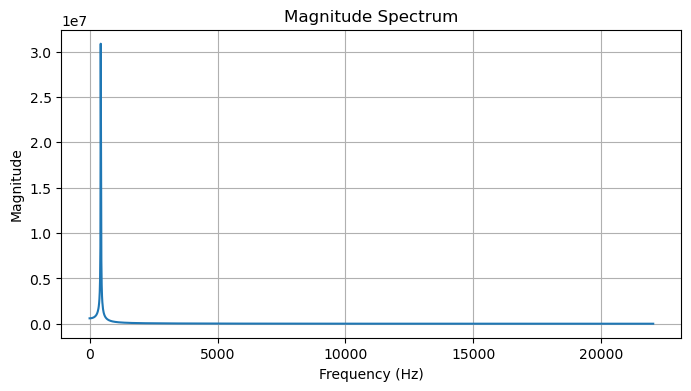

In [18]:
file_path = './audio/Sine_wave_440.wav'

# Read the wav file
sample_rate, data = wavfile.read(file_path)

print(len(data))

# Take the fourier transform of the wav file, reduce the size for memory efficiency TODO: figure out optimal n
fft_result = np.fft.fft(data, len(data)//64)

print(len(fft_result))

# Frequencies corresponding to the FFT result
frequencies = np.fft.fftfreq(len(fft_result), 1/sample_rate)

# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(frequencies)//2])
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

Above we can see a plot of the fourier transform, with a clear spike at 440Hz

### Training the Hopfield network

The fourier data is essentially 1D - the frequency is an index for an array of magnitudes. To convert between indices and frequencies, we can use the following formula:

$$Index = \left \lfloor \frac{Frequency \times N}{Sample Rate} \right \rfloor$$

Where $N$ is the size of the fourier transform data.

Since we only want to focus on the positive frequencies, we will take the first half of the fourier transform array.

In [26]:
# Get the data we want to memorize
from tqdm import tqdm


positive_fft = np.abs(fft_result)[:len(frequencies)//2]
print(len(frequencies))

# Initialize the Hopfield network
model = HopfieldNetwork()

# Only one data point to train, but input needs to be a list
train_data = [positive_fft]

# Train the weights in the network
model.train_weights([positive_fft])

3445
Start to train weights...
Weights initialized


100%|██████████| 1/1 [00:00<00:00, 44.03it/s]

Hebb rule step done


### Adding noise to the original audio

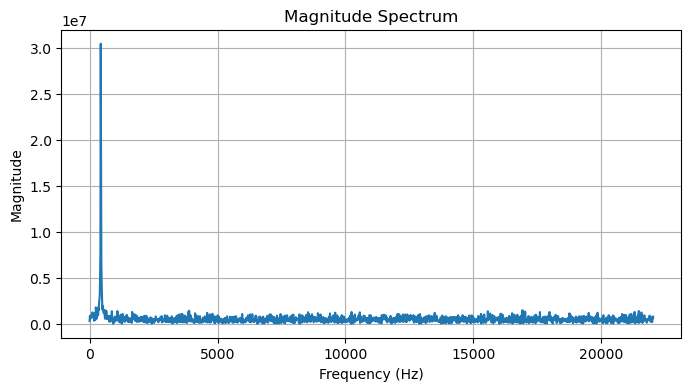

In [73]:
# Generate white noise
noise_level = 10000
noise = np.random.normal(0, noise_level, len(data))

# Add the noise to the audio data
noisy_audio = data + noise

# Clip the values to the valid range for 16-bit PCM audio
noisy_audio = np.clip(noisy_audio, -32768, 32767).astype(np.int16)

# Get the fourier transform of the data
noisy_fft = np.fft.fft(noisy_audio, len(noisy_audio)//64)

# Plot the magnitude spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(noisy_fft)[:len(frequencies)//2])
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()

### Make prediction (recover original audio)

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 15.47it/s]

Show prediction results...


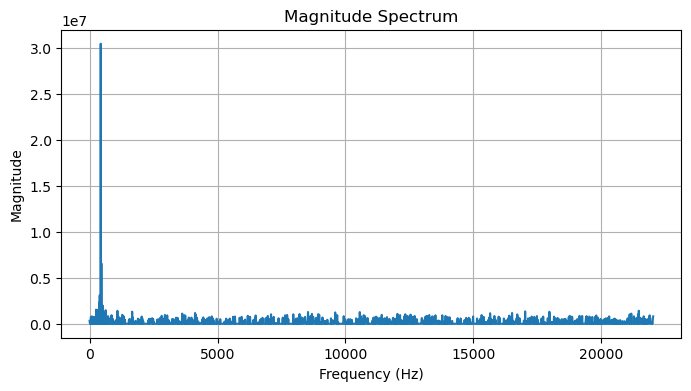

Show network weights matrix...


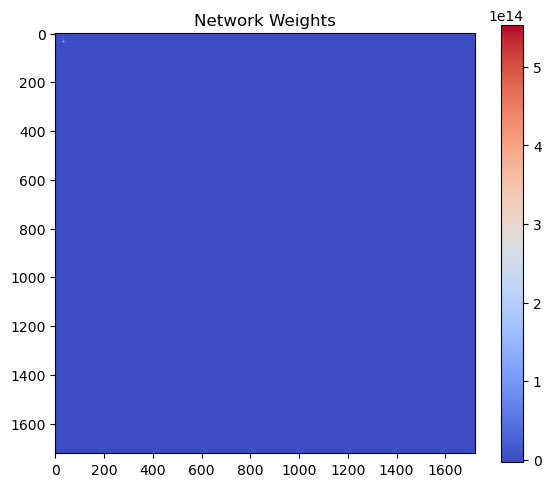

[[ 0.00000000e+00  2.55437095e+11  2.56308756e+11 ... -4.54647767e+10
  -4.54757949e+10 -4.54705357e+10]
 [ 2.55437095e+11  0.00000000e+00  2.56581321e+11 ... -4.55131259e+10
  -4.55241523e+10 -4.55188890e+10]
 [ 2.56308756e+11  2.56581321e+11  0.00000000e+00 ... -4.56684380e+10
  -4.56795013e+10 -4.56742216e+10]
 ...
 [-4.54647767e+10 -4.55131259e+10 -4.56684380e+10 ...  0.00000000e+00
   8.10275994e+09  8.10182349e+09]
 [-4.54757949e+10 -4.55241523e+10 -4.56795013e+10 ...  8.10275994e+09
   0.00000000e+00  8.10378598e+09]
 [-4.54705357e+10 -4.55188890e+10 -4.56742216e+10 ...  8.10182349e+09
   8.10378598e+09  0.00000000e+00]]


In [74]:
# Get just the positive frequencies
positive_noisy_fft = np.abs(noisy_fft)[:len(frequencies)//2]

predicted = model.predict([positive_noisy_fft], num_iter=20, threshold=50, asyn=True)
print("Show prediction results...")
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], predicted[0])
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid()
plt.show()
print("Show network weights matrix...")
model.plot_weights()
print(model.W)

### Varying number of iterations

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 431.96it/s]

Show prediction results for num_iter=0...


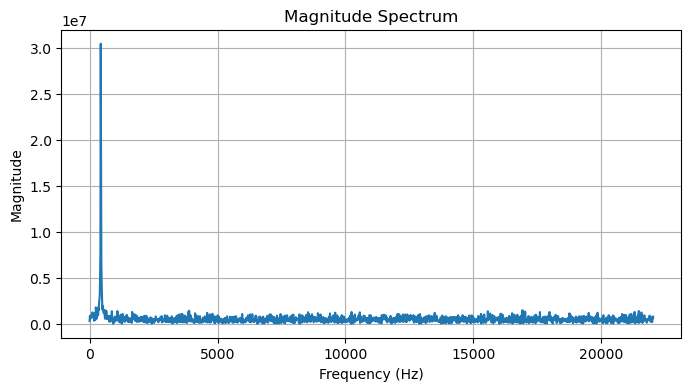

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 23.82it/s]


Show prediction results for num_iter=10...


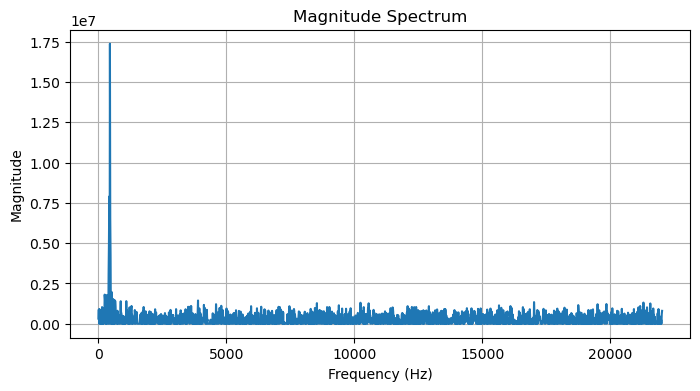

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


Show prediction results for num_iter=20...


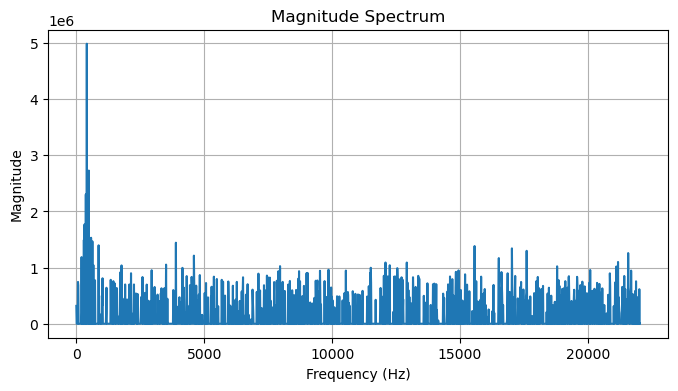

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


Show prediction results for num_iter=30...


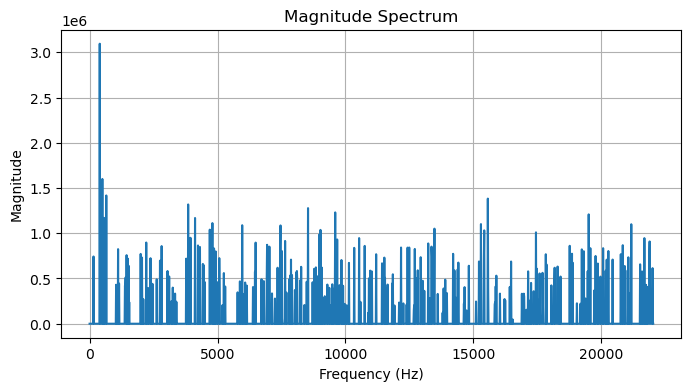

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Show prediction results for num_iter=40...


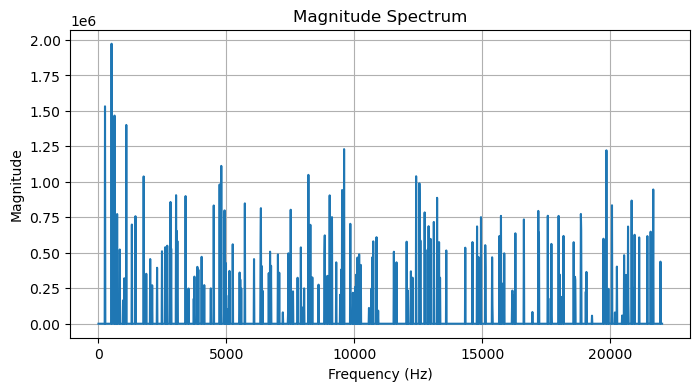

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]


Show prediction results for num_iter=50...


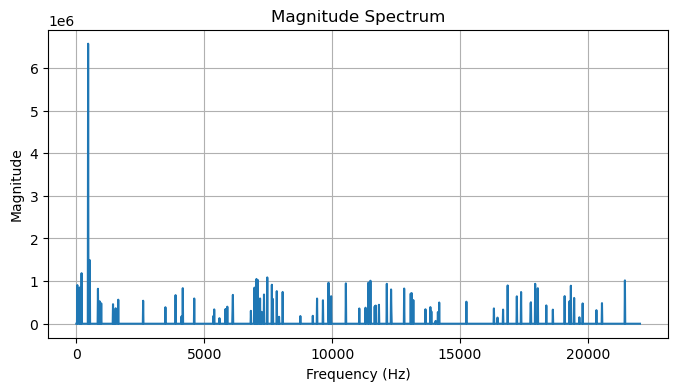

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


Show prediction results for num_iter=60...


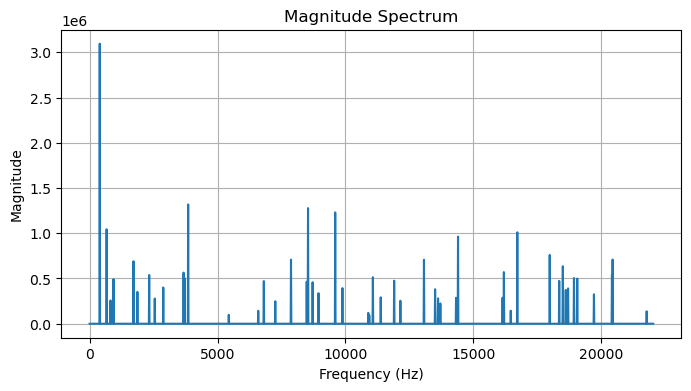

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

Show prediction results for num_iter=70...


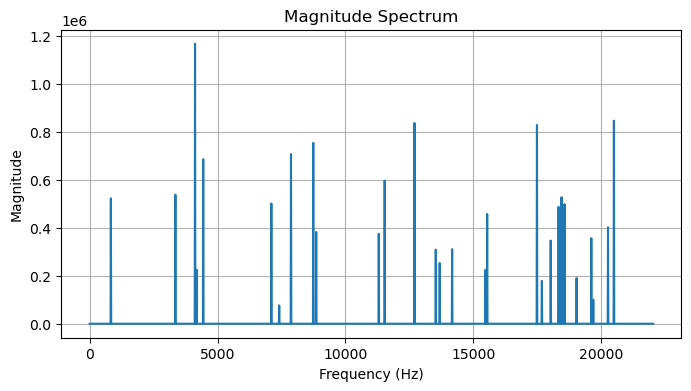

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

Show prediction results for num_iter=80...


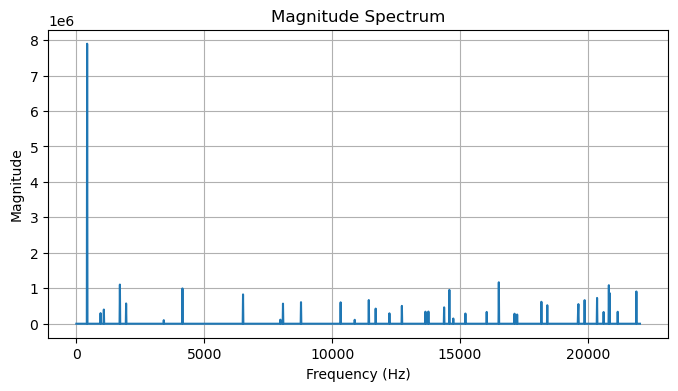

Start to predict...


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


Show prediction results for num_iter=90...


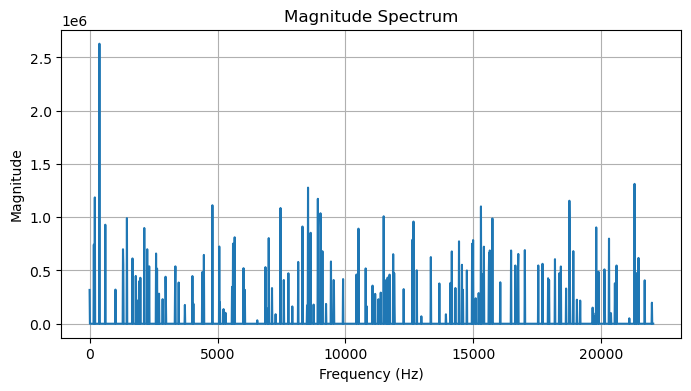

In [75]:
for i in range(0, 100, 10):
    predicted = model.predict([positive_noisy_fft], num_iter=i, threshold=50, asyn=True)
    print(f"Show prediction results for num_iter={i}...")
    plt.figure(figsize=(8, 4))
    plt.plot(frequencies[:len(frequencies)//2], predicted[0])
    plt.title('Magnitude Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.show()